In [1]:
import tensorflow as tf
#import socket
GPU_mode = 0
if GPU_mode:
    num_GPU =0# GPU  to use, can be 0, 2
    mem_growth = True
    print('Tensorflow version: ', tf.__version__)
    gpus = tf.config.experimental.list_physical_devices("GPU")
    print('Number of GPUs available :', len(gpus))
    tf.config.experimental.set_visible_devices(gpus[num_GPU], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[num_GPU], mem_growth)
    print('Used GPU: {}. Memory growth: {}'.format(num_GPU, mem_growth))

    
import numpy as np
import time 
import os
# import matplotlib.pyplot as plt
import scipy.io as sio
import pickle
#import h5py
#import pandas as pd
from datetime import datetime
# from Data_conv import Data
from Data0 import Data
from Plot_results_downlink import Plot

# from UNNdebug import UNN
from UNN_downlink import UNN
from Loss_downlink import Loss
print('done')

done


In [2]:
#------------------------------------------
# tf.keras.backend.set_floatx('float64')
#train_iterations = 100
batch_size =50
# train_per_database=100
# database_size=batch_size*train_per_database
EPOCHS =int(100e3)
Nuser = 30
Nap = 30
#Lambda=.001
#alpha=1
Id_save='2'
P_over_noise=120; # dB
# cost_type='maxmin'
cost_type='maxproduct'

In [8]:
def load_model(model, fn):
    with open(fn, 'rb') as f:
        W = pickle.load(f)
        # model = pickle.load(f)
    model.set_weights(W[0])
    model.Xin_av = W[1]
    model.Xin_std = W[2]
    
data=Data(Nuser)
G_batch,p_frac=data(batch_size,.7)
# xin=np.reshape(G_batch,[batch_size,-1])
SNR = np.power(10,P_over_noise/10)*G_batch
xin=np.reshape(np.log(SNR),[SNR.shape[0],-1])
# xin=np.log(np.diagonal(SNR,axis1=1,axis2=2))
# xin = tf.linalg.diag_part(SNR)

unn=UNN(Nap,Nuser,cost_type) 
cost,SIR,min_SIR= unn(xin,SNR)
# unn.Xin_std=1
current_dir = os.getcwd()
path = os.path.join(current_dir, 'models', cost_type+'UNN.mod')
load_model(unn, path)
  
# G_batch, p_frac = data(2 * batch_size, .5)
# xin=np.reshape(G_batch,[batch_size,-1])
SNR = np.power(10, P_over_noise / 10) * G_batch
xin = np.reshape(np.log(SNR), [SNR.shape[0], -1])
# xin = tf.linalg.diag_part(SNR)
xin=(xin-unn.Xin_av)/unn.Xin_std
cost,SINR,min_SINR = unn.Loss(SNR,unn.Network(xin))
print('Test cost is ',cost.numpy(),' min_SINR is ',min_SINR.numpy())

Test cost is  -0.321715  min_SINR is  -1.3419185


In [7]:
unn.Xin_std.shape

(900,)

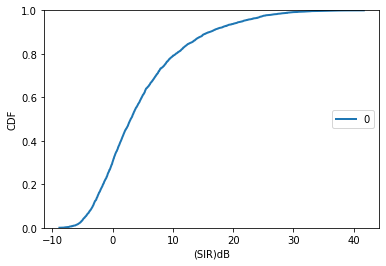

In [10]:
RP=Plot()
SIR_NN=RP.sinr_av(SNR,unn.Network(xin),Nap,Nuser)
# SIR_frac=RP.sinr_av(SNR,tf.math.log(p_frac),Nap,Nuser)
plot=Plot()
sir_vec=[SIR_NN.numpy()]
plot.cdfplot(sir_vec)


50